In [ ]:
#-*- coding: utf-8 -*-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/StatisticalLearningTheoryTeamProject

/content/drive/.shortcut-targets-by-id/1laojbhC7wFZCdac_KFAAlw6158K2SdSA/StatisticalLearningTheoryTeamProject


In [ ]:
import os
from glob import glob
from typing import Tuple, Sequence, Callable

import numpy as np
import pandas as pd

import PIL
from PIL import Image
from matplotlib.pyplot import imshow

import torch
import torch.optim as optim
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

!pip install torchinfo
from torchinfo import summary

import torchvision
from torchvision import transforms
from torchvision.models import resnet50

from tqdm.notebook import tqdm

In [ ]:
# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content/drive/.shortcut-targets-by-id/1laojbhC7wFZCdac_KFAAlw6158K2SdSA/StatisticalLearningTheoryTeamProject


In [ ]:
# 데이터 경로 설정

path = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/'

batch_size = 32
num_epochs = 10
learning_rate = 0.001

labels = {"circular_alopecia": 0, "keratosis": 1,
          "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}


In [ ]:
# gpu 사용중일땐 cuda, gpu 사용 불가능할땐 cpu 사용.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

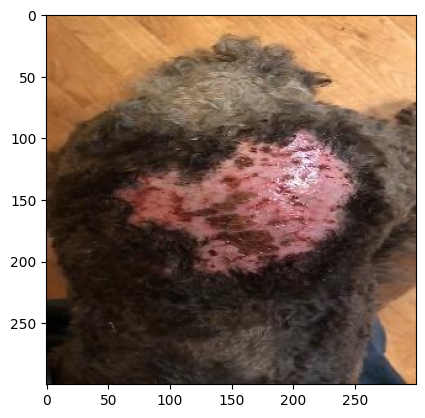

In [ ]:
# 이미지 확인

img = Image.open(path + 'train/skin_lesions_00000999_jpg.rf.c0731ac2275a98f20569291f8ad92967.jpg')
imshow(np.asarray(img))

In [ ]:
# 데이터프레임 재생성(모델 훈련 시 시간 많이 걸리지 않도록)

# CSV 파일 읽기 (파일명과 레이블이 포함된 CSV 파일)
csv_path = path + "train_source.csv"
df = pd.read_csv(csv_path)

train_images = []
train_labels = []

for filename in tqdm(glob(path + "train/*.jpg")):
    # 파일명에서 이미지 ID 추출
    img_id = os.path.basename(filename)

    # CSV 파일에서 이미지 ID에 해당하는 레이블 찾기
    label_row = df[df['filename'] == img_id]

    # 레이블이 존재하는 경우에만 처리
    if not label_row.empty:
        an_img = PIL.Image.open(filename)  # 이미지를 읽습니다.
        img_array = np.array(an_img)  # 이미지 데이터를 숫자로 변환합니다.
        train_images.append(img_array)  # 리스트에 데이터 추가.

    # CSV 파일에서 레이블을 추출하여 추가
        label_idx = label_row.iloc[0]['class']
        label_mapping = {"circular_alopecia": 0, "keratosis": 1, "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}
        label = label_mapping[label_idx]
        train_labels.append(label)

  0%|          | 0/12791 [00:00<?, ?it/s]

In [ ]:
# 같은 형식으로 검증데이터 다운

csv_path = path + "val_source.csv"
df = pd.read_csv(csv_path)

val_images = []
val_labels = []

for filename in tqdm(glob(path + "valid/*.jpg")):
    # 파일명에서 이미지 ID 추출
    img_id = os.path.basename(filename)

    # CSV 파일에서 이미지 ID에 해당하는 레이블 찾기
    label_row = df[df['filename'] == img_id]

    # 레이블이 존재하는 경우에만 처리
    if not label_row.empty:
        an_img = PIL.Image.open(filename)  # 이미지를 읽습니다.
        img_array = np.array(an_img)  # 이미지 데이터를 숫자로 변환합니다.
        val_images.append(img_array)  # 리스트에 데이터 추가.

    # CSV 파일에서 레이블을 추출하여 추가
        label_idx = label_row.iloc[0]['class']
        label_mapping = {"circular_alopecia": 0, "keratosis": 1, "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}
        label = label_mapping[label_idx]
        val_labels.append(label)



  0%|          | 0/1308 [00:00<?, ?it/s]

In [ ]:

csv_path = path + "test_source.csv"
df = pd.read_csv(csv_path)

test_images = []
test_labels = []

for filename in tqdm(glob(path + "test/*.jpg")):
    # 파일명에서 이미지 ID 추출
    img_id = os.path.basename(filename)

    # CSV 파일에서 이미지 ID에 해당하는 레이블 찾기
    label_row = df[df['filename'] == img_id]

    # 레이블이 존재하는 경우에만 처리
    if not label_row.empty:
        an_img = PIL.Image.open(filename)  # 이미지를 읽습니다.
        img_array = np.array(an_img)  # 이미지 데이터를 숫자로 변환합니다.
        test_images.append(img_array)  # 리스트에 데이터 추가.

    # CSV 파일에서 레이블을 추출하여 추가
        label_idx = label_row.iloc[0]['class']
        label_mapping = {"circular_alopecia": 0, "keratosis": 1, "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}
        label = label_mapping[label_idx]
        test_labels.append(label)

  0%|          | 0/599 [00:00<?, ?it/s]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, transform, mode = 'train'):
        self.transform = transform
        if mode == 'train':
            self.img_list = train_images
            self.img_labels = train_labels
        elif mode == 'test':
            self.img_list = test_images
            self.img_labels = [0] * 10000 # 형식을 맞추기 위해
        elif mode == 'valid':
            self.img_list = val_images
            self.img_labels = val_labels

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        pil_image = Image.fromarray(self.img_list[idx])

        # 변환 후 PyTorch 텐서로 변환
        img = self.transform(pil_image)

        return img, self.img_labels[idx]
        # return self.transform(self.img_list[idx]), self.img_labels[idx]

In [ ]:
tensor = transforms.Compose([
        transforms.ToTensor()
        ])


train_set = CustomDataset(tensor, mode = 'train')
val_set = CustomDataset(tensor, mode = 'valid')
test_set = CustomDataset(tensor, mode = 'test')

In [ ]:
# image normalization

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_set]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_set]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.46318692 0.4102691 0.38380048
0.2533599 0.2401382 0.2344885


In [ ]:
transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])


In [ ]:
train_set.transform = transform
val_set.transform = transform
test_set.transform = transform

In [ ]:
train_set.__len__()

12587

In [ ]:
# 데이터셋 입력 확인

train_set.__getitem__(40)

(tensor([[[-1.8282, -1.8282, -1.8282,  ..., -1.8282, -1.8282, -1.8282],
          [-1.8282, -1.8282, -1.8282,  ..., -1.8282, -1.8282, -1.8282],
          [-1.8282, -1.8282, -1.8282,  ..., -1.8282, -1.8282, -1.8282],
          ...,
          [-1.8127, -1.8282, -1.8282,  ..., -1.8282, -1.8282, -1.8282],
          [-1.8282, -1.8282, -1.8282,  ..., -1.8282, -1.8282, -1.8282],
          [-1.8282, -1.8282, -1.8282,  ..., -1.8282, -1.8282, -1.8282]],
 
         [[-1.7085, -1.7085, -1.7085,  ..., -1.7085, -1.6921, -1.6921],
          [-1.7085, -1.7085, -1.7085,  ..., -1.7085, -1.6921, -1.6921],
          [-1.7085, -1.7085, -1.7085,  ..., -1.7085, -1.6921, -1.6921],
          ...,
          [-1.6921, -1.7085, -1.7085,  ..., -1.7085, -1.7085, -1.7085],
          [-1.7085, -1.7085, -1.7085,  ..., -1.7085, -1.7085, -1.7085],
          [-1.7085, -1.7085, -1.7085,  ..., -1.7085, -1.7085, -1.7085]],
 
         [[-1.6368, -1.6368, -1.6368,  ..., -1.6033, -1.5699, -1.5699],
          [-1.6368, -1.6368,

In [ ]:
train_loader = DataLoader(train_set, batch_size = batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size = batch_size, num_workers=2)

In [ ]:
for batch_idx, samples in enumerate(train_loader):
    if batch_idx > 0:
        break
    print(samples[0].shape)
    print(samples[1])

torch.Size([32, 3, 300, 300])
tensor([5, 2, 2, 1, 0, 2, 2, 4, 4, 0, 0, 5, 0, 0, 2, 5, 2, 3, 0, 2, 2, 1, 2, 5,
        5, 0, 4, 4, 5, 5, 4, 0])


In [ ]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet50(pretrained=True)
        self.classifier = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)

        return x

In [ ]:
model = Model().to(device)
print(summary(model, input_size = (1,3,32,32)))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
Model                                         [1, 10]                   --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 16, 16]           128
│    └─ReLU: 2-3                              [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                         [1, 64, 8, 8]             --
│    └─Sequential: 2-5                        [1, 256, 8, 8]            --
│    │    └─Bottleneck: 3-1                   [1, 256, 8, 8]            75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 8, 8]            70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 8, 8]            70,400
│    └─Sequential: 2-6                        [1, 512, 4, 4]            --
│    │    └─Bottleneck: 3-4                   [1, 512, 4, 4]            379,392

In [ ]:

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

model.train()

for epoch in range(num_epochs):
    for i, (images, targets) in enumerate(tqdm((train_loader), desc=f'Training Epoch {epoch+1}/{num_epochs}')):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        if (i + 1) % 394 == 0:
            max_vals, max_indices = torch.max(outputs, 1)
            acc = (targets == max_indices).float().mean()
            train_losses.append(loss.item())
            # train_accuracies.append(acc.item())
            print(f'Train - Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{len(train_loader)}, Loss: {loss.item():.5f}, Accuracy: {acc.item():.5f}')

    # 검증 데이터에 대한 손실값 계산 및 출력
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            max_vals, max_indices = torch.max(outputs, 1)
            acc = (targets == max_indices).float().mean()
            val_acc += acc.item()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_losses.append(val_loss)
    # val_accuracies.append(val_acc)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.5f}, Accuracy: {val_acc:.5f}')

    model.train()


Training Epoch 1/10:   0%|          | 0/394 [00:00<?, ?it/s]

Train - Epoch 1/10, Iteration 394/394, Loss: 0.05620, Accuracy: 1.00000


Validation Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Validation - Epoch 1/10, Loss: 0.03971, Accuracy: 0.98591


Training Epoch 2/10:   0%|          | 0/394 [00:00<?, ?it/s]

Train - Epoch 2/10, Iteration 394/394, Loss: 0.81414, Accuracy: 0.81818


Validation Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Validation - Epoch 2/10, Loss: 0.13851, Accuracy: 0.96535


Training Epoch 3/10:   0%|          | 0/394 [00:00<?, ?it/s]

Train - Epoch 3/10, Iteration 394/394, Loss: 0.00042, Accuracy: 1.00000


Validation Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Validation - Epoch 3/10, Loss: 0.04121, Accuracy: 0.98755


Training Epoch 4/10:   0%|          | 0/394 [00:00<?, ?it/s]

Train - Epoch 4/10, Iteration 394/394, Loss: 0.00368, Accuracy: 1.00000


Validation Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Validation - Epoch 4/10, Loss: 0.08605, Accuracy: 0.98427


Training Epoch 5/10:   0%|          | 0/394 [00:00<?, ?it/s]

Train - Epoch 5/10, Iteration 394/394, Loss: 0.10830, Accuracy: 0.90909


Validation Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Validation - Epoch 5/10, Loss: 0.04118, Accuracy: 0.98766


Training Epoch 6/10:   0%|          | 0/394 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

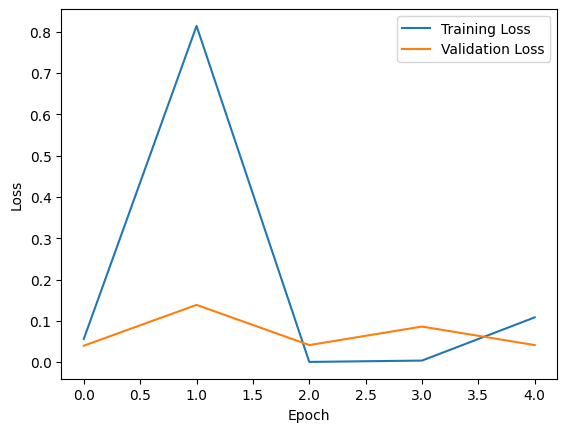

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('ResNet_loss_graph.png')

In [ ]:
model.eval() # 모델을 평가 상태로 설정

preds = [] # 예측값 저장용 배열 초기화

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc=f'Test Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)

        max_vals, max_indices = torch.max(outputs, 1)

        # 예측 결과 저장
        preds.append(max_indices.cpu().numpy())

Test Epoch 6/10:   0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
preds = np.expand_dims(preds, axis=0)
preds = np.concatenate(preds, axis=0)
preds

array([2, 4, 5, 4, 1, 2, 4, 2, 2, 4, 2, 4, 3, 2, 0, 2, 1, 1, 2, 0, 4, 4,
       3, 3, 5, 5, 3, 5, 3, 1, 2, 5, 4, 5, 2, 5, 2, 0, 0, 1, 0, 0, 1, 1,
       3, 0, 2, 2, 4, 2, 5, 5, 1, 4, 1, 2, 0, 3, 5, 5, 2, 3, 4, 0, 5, 4,
       2, 0, 4, 1, 5, 0, 2, 3, 3, 1, 5, 1, 0, 4, 1, 2, 4, 3, 3, 4, 0, 5,
       2, 3, 4, 2, 0, 5, 2, 5, 2, 5, 2, 3, 3, 5, 3, 1, 5, 1, 1, 5, 4, 5,
       2, 5, 2, 0, 4, 4, 0, 4, 2, 5, 2, 4, 0, 2, 2, 5, 3, 1, 5, 5, 2, 2,
       2, 2, 4, 1, 2, 5, 0, 5, 4, 5, 1, 4, 1, 3, 4, 4, 0, 4, 0, 3, 2, 5,
       1, 2, 1, 1, 2, 5, 1, 4, 4, 1, 4, 0, 1, 0, 0, 3, 0, 4, 4, 1, 5, 4,
       2, 4, 5, 1, 0, 5, 1, 2, 2, 1, 4, 2, 5, 5, 0, 5, 4, 4, 5, 5, 5, 0,
       2, 1, 3, 1, 1, 4, 2, 0, 5, 3, 4, 5, 0, 4, 5, 3, 2, 5, 3, 3, 2, 1,
       4, 0, 4, 1, 5, 4, 4, 3, 0, 3, 1, 1, 4, 0, 4, 5, 2, 2, 1, 1, 2, 0,
       5, 1, 3, 0, 5, 5, 1, 3, 3, 2, 4, 4, 1, 3, 5, 4, 4, 4, 1, 4, 0, 2,
       0, 4, 3, 5, 3, 5, 5, 5, 4, 5, 0, 2, 5, 2, 3, 5, 2, 0, 2, 0, 5, 4,
       3, 0, 5, 1, 1, 3, 2, 2, 5, 1, 5, 5, 1, 1, 1,

In [ ]:
true_labels = np.squeeze(test_labels).T
true_labels

array([2, 4, 5, 4, 1, 2, 4, 2, 2, 4, 2, 4, 3, 2, 0, 2, 1, 1, 2, 0, 4, 4,
       3, 3, 5, 5, 3, 5, 3, 1, 0, 5, 4, 5, 2, 5, 2, 0, 0, 1, 0, 0, 1, 1,
       3, 0, 2, 2, 4, 2, 5, 5, 1, 4, 1, 2, 0, 3, 5, 5, 2, 3, 4, 0, 5, 4,
       2, 0, 4, 1, 5, 0, 2, 3, 3, 1, 5, 1, 0, 4, 1, 2, 4, 3, 3, 4, 0, 5,
       2, 3, 4, 2, 0, 5, 2, 5, 2, 5, 2, 3, 3, 5, 3, 1, 5, 1, 1, 5, 4, 5,
       2, 5, 2, 0, 4, 4, 0, 4, 2, 5, 2, 4, 0, 2, 2, 5, 3, 1, 5, 5, 2, 2,
       2, 2, 4, 1, 2, 5, 0, 5, 4, 5, 1, 4, 1, 1, 4, 4, 0, 4, 0, 3, 2, 5,
       1, 2, 1, 1, 2, 5, 1, 4, 4, 1, 4, 0, 1, 0, 0, 3, 0, 4, 4, 1, 5, 4,
       2, 4, 5, 1, 0, 5, 1, 2, 2, 1, 4, 2, 5, 5, 0, 5, 4, 4, 5, 5, 5, 0,
       2, 1, 3, 1, 1, 4, 2, 0, 5, 3, 4, 5, 0, 4, 5, 3, 2, 5, 3, 3, 2, 3,
       4, 0, 4, 1, 5, 4, 4, 3, 0, 3, 1, 1, 4, 0, 4, 5, 2, 2, 1, 1, 2, 0,
       5, 1, 3, 0, 5, 5, 1, 3, 3, 2, 4, 4, 1, 3, 5, 4, 4, 4, 1, 4, 0, 2,
       0, 4, 3, 5, 3, 5, 5, 5, 4, 5, 0, 2, 5, 2, 3, 5, 2, 0, 2, 0, 5, 4,
       3, 0, 5, 1, 1, 3, 2, 2, 5, 1, 5, 5, 1, 1, 1,

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# 정확도 계산
accuracy = accuracy_score(true_labels, preds)
print(f'Accuracy: {accuracy:.5f}')

# 분류 보고서 출력
print("Classification Report:")
print(classification_report(true_labels, preds))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(true_labels, preds)
print("Confusion Matrix:")
print(conf_matrix)

# F1 스코어 계산
f1 = f1_score(true_labels, preds, average='macro')
print(f'F1 Score: {f1:.5f}')

Accuracy: 0.98664
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        87
           1       0.98      0.98      0.98       100
           2       0.99      1.00      1.00       101
           3       0.98      0.94      0.96        90
           4       0.99      1.00      1.00       108
           5       1.00      1.00      1.00       113

    accuracy                           0.99       599
   macro avg       0.99      0.99      0.99       599
weighted avg       0.99      0.99      0.99       599

Confusion Matrix:
[[ 86   0   1   0   0   0]
 [  0  98   0   2   0   0]
 [  0   0 101   0   0   0]
 [  2   2   0  85   1   0]
 [  0   0   0   0 108   0]
 [  0   0   0   0   0 113]]
F1 Score: 0.98563


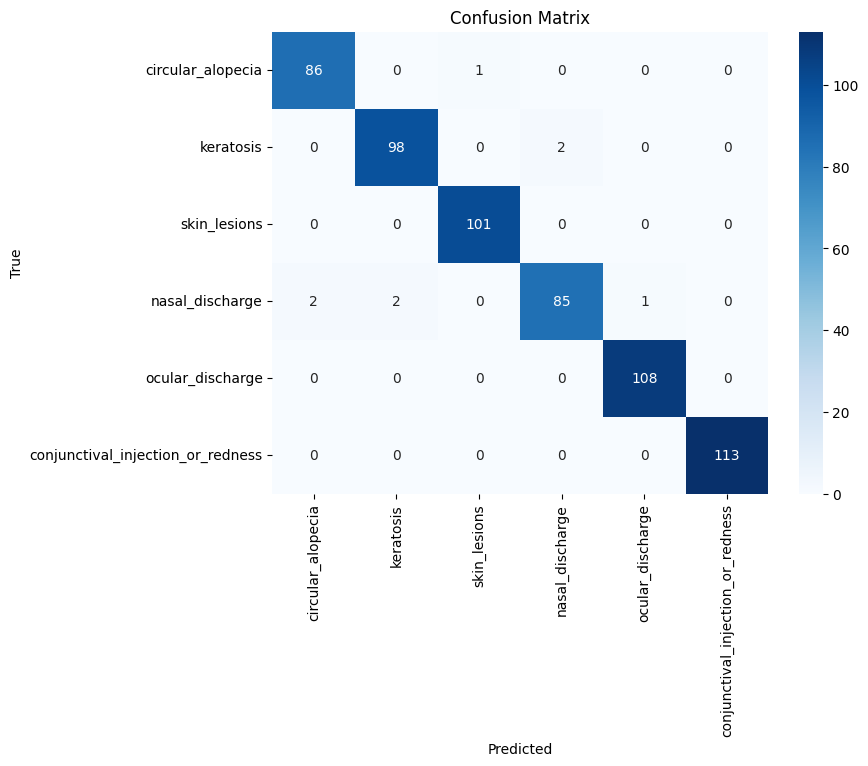

In [ ]:
import seaborn as sns

# Classification Report Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('resNet_ConfusionMatrix.png')
